In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
%matplotlib inline

/tmp/ipykernel_2484/3090431912.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# there is currently a significant amount of data for these runs
expts_full = ['historical','ssp126', 'ssp245', 'ssp370', 'ssp585', 'piControl']

query = dict(
    experiment_id=expts_full,
    table_id='Amon',                           
    variable_id=['tas', 'pr', 'ua', 'va'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset_var = [col_subset.search(variable_id=var_name) for var_name in query['variable_id']]
#col_subset_tas = col_subset.search(variable_id='tas')
#col_subset_pr = col_subset.search(variable_id='pr')

col_subset_var[0].df[
    ['source_id',"experiment_id", "variable_id", "table_id"]
].nunique()

source_id        25
experiment_id     6
variable_id       1
table_id          1
dtype: int64

In [7]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True, decode_times=True, use_cftime=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = []
for col_subset in col_subset_var :
    dset = defaultdict(dict)

    for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
        dset[group[0]][group[1]] = open_delayed(df)
    dsets.append(dset)

In [8]:
with progress.ProgressBar():
    dsets_ = [dask.compute(dict(dset))[0]for dset in dsets]

[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s


In [9]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    lat_var = str(get_lat_name(ds))
    #print(type(lat_var))
    lat = ds[lat_var].sel({lat_var : slice(-30, 30)})
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds.sel({lat_var : slice(-30, 30)}) * weight).mean(other_dims)


In [12]:
from toolz.functoolz import juxt
expts = expts_full[:-1]
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned_list = []
for dset_ in dsets_[:2]:
    j=0
    dsets_aligned = {}
    for k, v in tqdm(dset_.items()):
        
        expt_dsets = v.values()
        if any([d is None for d in expt_dsets]):
            print(f"Missing experiment for {k}")
            continue

        for ds in expt_dsets:
            ds.coords['year'] = ds.time.dt.year
    
        # workaround for
        # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
        dsets_ann_mean = [v[expt].pipe(global_mean)
                                .swap_dims({'time': 'year'})
                                .drop('time')
                                .coarsen(year=12).mean()
                                for expt in expts]

        # align everything with the 4xCO2 experiment

        dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                    dim=expt_da)
    dsets_aligned_list.append(dsets_aligned)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
with progress.ProgressBar():
    dsets_aligned_list_1 = dask.compute(dsets_aligned_list[0])[0]
        
with progress.ProgressBar():
    dsets_aligned_list_2 = dask.compute(dsets_aligned_list[1])[0]

[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 41.7s


In [17]:
dsets_algned_list_ = [dsets_aligned_list_1, dsets_aligned_list_2]
type(dsets_algned_list_[0])

dict

In [18]:
source_ids = [list(dsets_aligned_.keys()) for dsets_aligned_ in dsets_algned_list_]
#source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
#                         coords={'source_id': source_ids})
big_ds = []
for idx, dsets_aligned_ in enumerate(dsets_algned_list_):
    source_da = xr.DataArray(source_ids[idx], dims='source_id', name='source_id',
                         coords={'source_id': source_ids[idx]})
    big_ds.append(xr.concat([ds.reset_coords(drop=True)
                        for ds in dsets_aligned_.values()],
                        dim=source_da))

In [19]:
ds_all = big_ds[0].assign(pr=big_ds[1].pr)
ds_all.to_netcdf('/home/jovyan/pangeo/data/tas_pr_globaltropics_timeseries.nc')
ds_all

<xarray.Dataset>
Dimensions:        (source_id: 25, year: 451, experiment_id: 5)
Coordinates:
  * source_id      (source_id) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' ... 'ssp585'
Data variables:
    tas            (source_id, experiment_id, year) float64 297.6 297.6 ... nan
    pr             (source_id, experiment_id, year) float64 4.342e-05 ... nan

In [20]:
#ds_all = xr.open_dataset('/home/jovyan/pangeo/data/tas_pr_globaltropics_timeseries.nc')
small_ds = ds_all.sel(year=slice(1950,2100)).rolling(year=2).mean()

cl_t0, cl_tf = 1984, 2014
clim_ds = small_ds.sel(experiment_id='historical', year=slice(cl_t0, cl_tf)).mean(dim=('year')) 

dev_ds_pr = ((small_ds.pr - clim_ds.pr)/clim_ds.pr)*100 
dev_ds_tas = small_ds.tas - clim_ds.tas
ens_ds_pr = dev_ds_pr.mean(dim='source_id')
print(ens_ds_pr.shape)

ens_ds_tas = dev_ds_tas.mean(dim='source_id')
ens_ds_tas.shape

(5, 151)


(5, 151)

In [ ]:
import itertools as it
spread_max_pr = np.empty(shape=(5, 151))
spread_min_pr = np.empty(shape=(5, 151))

spread_max_tas = np.empty(shape=(5, 151))
spread_min_tas = np.empty(shape=(5, 151))

for i,j in it.product(range(5), range(151)):  ##instead of nested for loops. works same.
    spread_max_pr[i, j] = np.nanmax(dev_ds_pr[:, i, j]-ens_ds_pr[i, j])
    spread_min_pr[i, j] = np.nanmin(dev_ds_pr[:, i, j]-ens_ds_pr[i, j])
    
    spread_max_tas[i, j] = np.nanmax(dev_ds_tas[:, i, j]-ens_ds_tas[i, j])
    spread_min_tas[i, j] = np.nanmin(dev_ds_tas[:, i, j]-ens_ds_tas[i, j])

spread_tas ={'max_vals' : spread_max_tas, 
             'min_vals' : spread_min_tas}

spread_pr ={'max_vals' : spread_max_pr, 
             'min_vals' : spread_min_pr}

spr = [spread_tas, spread_pr]

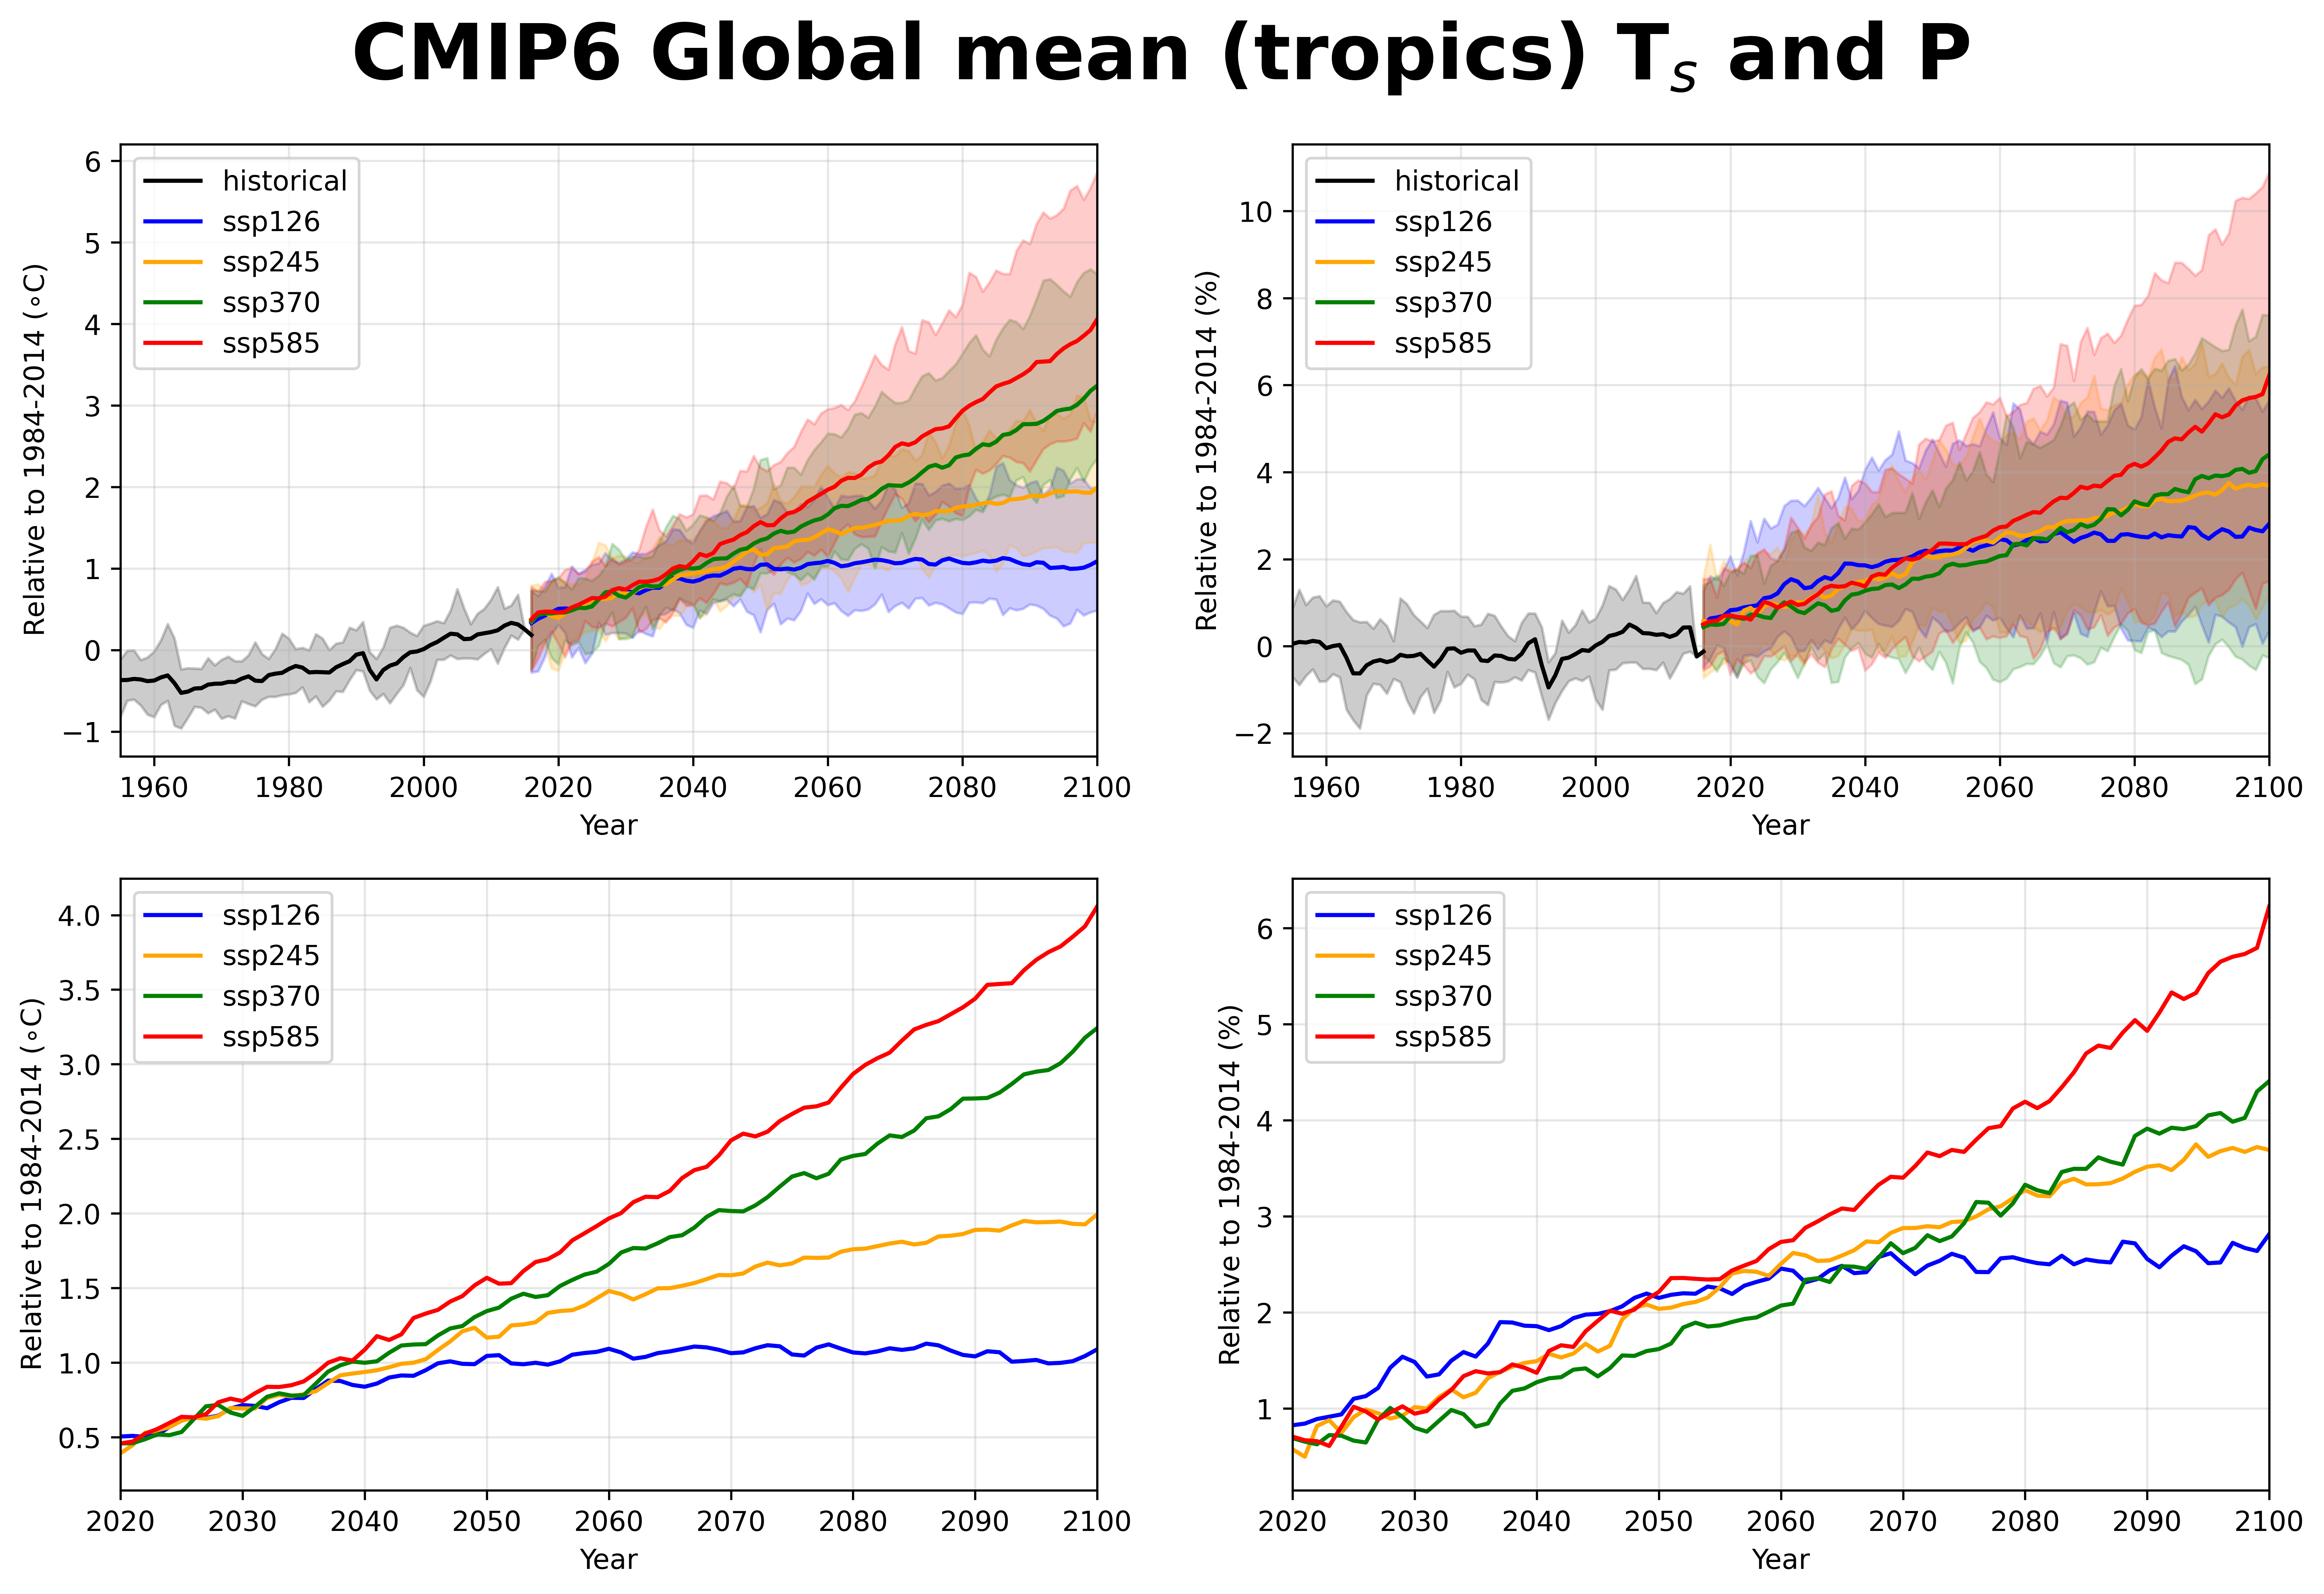

In [23]:
from matplotlib import cm
import matplotlib.colors as mcl
cmap = cm.turbo
cl = ['k']+[mcl.rgb2hex(cmap(i)[:3]) for i in range(0,cmap.N,70)]
cl = ['k'] + ['blue', 'orange', 'green','red']

ncols, nrows=2,2
fig, axs = plt.subplots(nrows, ncols, dpi=600, figsize = (14,9))
ens_dss = [ens_ds_tas, ens_ds_pr]

y_l = [f'Relative to {cl_t0}-{cl_tf} ($\circ$C)', 
       f'Relative to {cl_t0}-{cl_tf} (%)']


for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        ens_ds = ens_dss[j]
        if i==0:
            for idx,v in enumerate(ens_ds.experiment_id):
                len(ens_ds.year)
                ax.plot(ens_ds.year, ens_ds[ens_ds['experiment_id']==v.values].squeeze(), label = v.values, c=cl[idx])
                ax.fill_between(ens_ds.year, ens_ds[ens_ds['experiment_id']==v.values].squeeze()+spr[j]['max_vals'][idx,:], 
                                 ens_ds[ens_ds['experiment_id']==v.values].squeeze()+spr[j]['min_vals'][idx, :], alpha=0.2, color=cl[idx] )
                ax.set_xlim(1955,2100)
        else:
            for idx,v in enumerate(ens_ds.experiment_id[1:]):
                ax.plot(ens_ds.year, ens_ds[ens_ds['experiment_id']==v.values].squeeze(), label=v.values, c=cl[idx+1])
                ax.set_xlim(2020,2100)
        ax.set_xlabel('Year')
        ax.set_ylabel(y_l[j])
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)

fig.suptitle('CMIP6 Global mean (tropics) T$_s$ and P', x=0.5, y =0.95, fontsize=28, weight='bold')
plt.savefig('/home/jovyan/pangeo/plot/tas_pr_tropics_timeseries.png', bbox_inches='tight', facecolor='white')